# Photometric Redshift Determination for SDSS+SpIES Quasar Candidates

Sandbox for exploring photo-$z$ algorithms using Scikit-Learn.

First load in all of the known quasars with Spitzer-IR data (can actually skip down to next section, just leaving this here in case I need it later).

## Known Quasars

All known quasars are in<br>
/Users/gtr/Work/sdss/mastercat/GTR-ADM-QSO-master-sweeps-Feb5-2016.zspeconly.fits<br>
which are all the confirmed quasasrs in the main master catalog in<br>
GTR-ADM-QSO-ir-testhighz_kdephotoz_lup_2016_quasar_candidates.zspec.fits

In [2]:
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
data3 = Table.read('/Users/gtr/Work/sdss/mastercat/GTR-ADM-QSO-master-sweeps-Feb5-2016.zspeconly.fits')

/Users/gtr/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
print len(data3)
#data3.keys()

437472


In [4]:
# Get rid of objects with negative fluxes
mask = ( (data3['PSFFLUX'][:,0]>0) & (data3['PSFFLUX'][:,1]>0) & (data3['PSFFLUX'][:,2]>0) & (data3['PSFFLUX'][:,3]>0) & (data3['PSFFLUX'][:,4]>0)  )
data3 = data3[mask]

Convert from maggies to magnitudes, use the "clean" fluxes when available, but only if >0 to avoid problems with logs.

In [5]:
data3['u'] = 22.5-2.5*np.log10(np.where(((data3['PSF_CLEAN_NUSE'][:,0]>0) & (data3['PSFFLUX_CLEAN'][:,0]>0)), data3['PSFFLUX_CLEAN'][:,0], data3['PSFFLUX'][:,0]))
data3['g'] = 22.5-2.5*np.log10(np.where(((data3['PSF_CLEAN_NUSE'][:,1]>0) & (data3['PSFFLUX_CLEAN'][:,1]>0)), data3['PSFFLUX_CLEAN'][:,1], data3['PSFFLUX'][:,1]))
data3['r'] = 22.5-2.5*np.log10(np.where(((data3['PSF_CLEAN_NUSE'][:,2]>0) & (data3['PSFFLUX_CLEAN'][:,2]>0)), data3['PSFFLUX_CLEAN'][:,2], data3['PSFFLUX'][:,2]))
data3['i'] = 22.5-2.5*np.log10(np.where(((data3['PSF_CLEAN_NUSE'][:,3]>0) & (data3['PSFFLUX_CLEAN'][:,3]>0)), data3['PSFFLUX_CLEAN'][:,3], data3['PSFFLUX'][:,3]))
data3['z'] = 22.5-2.5*np.log10(np.where(((data3['PSF_CLEAN_NUSE'][:,4]>0) & (data3['PSFFLUX_CLEAN'][:,4]>0)), data3['PSFFLUX_CLEAN'][:,4], data3['PSFFLUX'][:,4]))

Cut some questionable data

In [6]:
mask2 = ((data3['u']>35) | (data3['g']>30) | (data3['r']>30) | (data3['i']>30) | (data3['z']>30))
data3 = data3[mask2]

In [4]:
X = np.vstack([ data3['u'], data3['g'], data3['r'], data3['i'], data3['z']]).T
y = np.array(data3['ZSPEC'])

In [20]:
ug = np.array(data3['u']-data3['g'])
gr = data3['g']-data3['r']

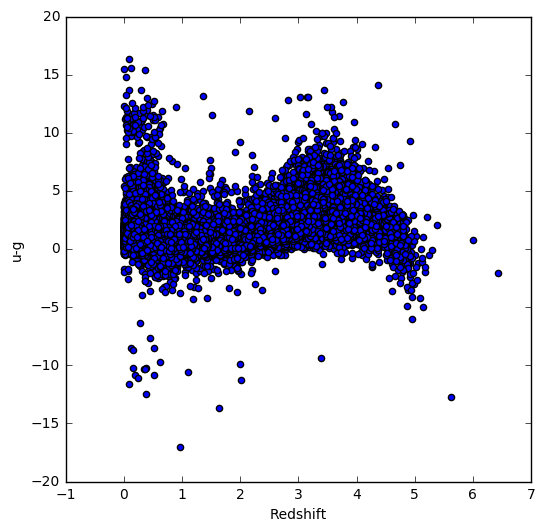

In [14]:
fig = plt.figure(figsize=(6,6))
#plt.scatter(y,(X[:,0]-X[:,1]))
plt.scatter(y,ug)
plt.xlabel('Redshift')
plt.ylabel('u-g')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report

# Split the training data into training and test sets for cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

## Known Quasars II

Hmm, actually I think that it makes more sense to use the training data as the input for a photo-z algorithm.  Because I've already weeded out the bad data.  The $z<3.5$ quasars are labeled as "stars", but so what.  The quasars are all still in the file.

So, as in the SpIESHighCandidateSelection notebook, we want to use<br>
`GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits`

In [1]:
# Read in data file
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
data = Table.read('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits')

# Remove stars
qmask = (data['zspec']>0)
qdata = data[qmask]
print len(qdata)

# X is in the format need for all of the sklearn tools, it just has the colors
X = np.vstack([ qdata['ug'], qdata['gr'], qdata['ri'], qdata['iz'], qdata['zs1'], qdata['s1s2']]).T
#y = np.array(data['labels'])
y = np.array(qdata['zspec'])


from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
# Split the training data into training and test sets for cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)


# For algorithms that need scaled data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)  # Don't cheat - fit only on training data
XStrain = scaler.transform(Xtrain)
XStest = scaler.transform(Xtest)  # apply same transformation to test data

#Include more attributes to see if that helps at all with classification
#XX = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], data['zs1'], data['s1s2'], data['imag'], data['extinctu'], data['morph']]).T

/Users/gtr/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


234416


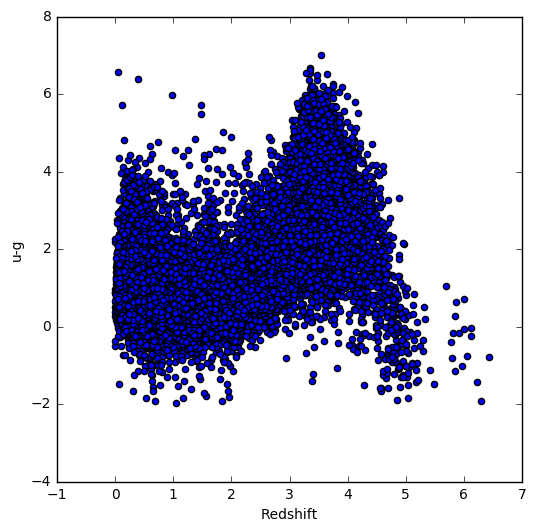

In [2]:
fig = plt.figure(figsize=(6,6))
plt.scatter(y,qdata['ug'])
plt.xlabel('Redshift')
plt.ylabel('u-g')
plt.show()

In [3]:
# Same plot, but with KDE

Xplot = np.vstack([ qdata['zspec'], qdata['ug'] ]).T

from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
kde.fit(Xplot) #fit the model to the data
u = np.linspace(-0.1,7,100)
v = np.linspace(-2.5,7.5,100)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

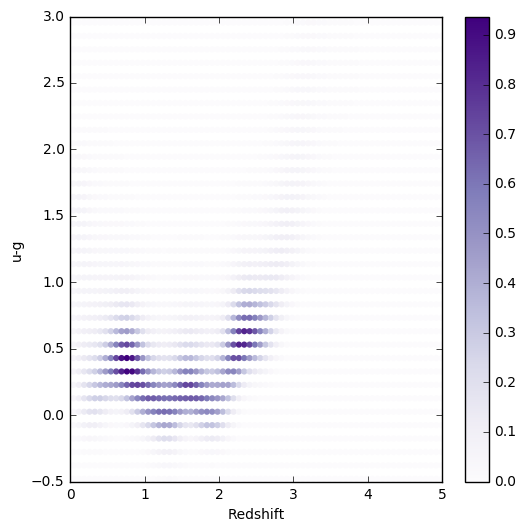

In [4]:
fig = plt.figure(figsize=(6,6))
plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None")
plt.xlabel('Redshift')
plt.ylabel('u-g')
plt.xlim([0,5])
plt.ylim([-0.5,3])
plt.colorbar()
plt.show()

Use Coleman and Tina's densityplot instead.  Don't know why it won't do the color bar or why it won't show the full plot at once.

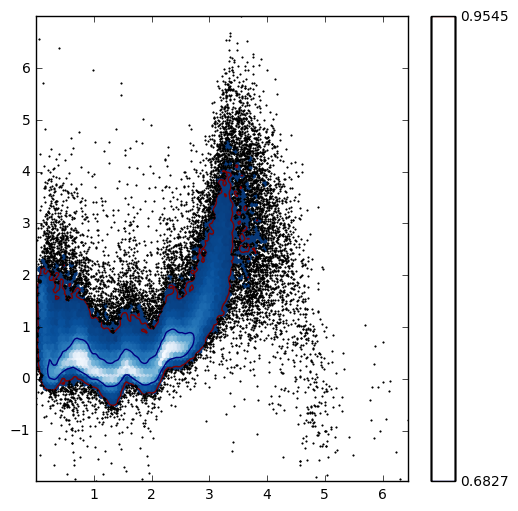

In [3]:
from densityplot import *
from pylab import *

fig = plt.figure(figsize=(6,6))
hex_scatter(y,qdata['ug'], min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.colorbar()

## Test data

We have read in the known quasars above, now we need to read in the test set objects.    

* If we want more than just the colors, then we can use:

Using <br>
`GTR-ADM-QSO-ir_good_test_2016n.fits`<br>
which I kludged together from<br>
GTR-ADM-QSO-ir_classifiers_good_test_2016.dat (and .fits) <br>
GTR-ADM-QSO-ir_others_good_test_2016.dat (and .fits) <br>
GTR-ADM-QSO-ir_photoz_in7_good_test_2016.dat (and .fits)

This was built with a combination of 
combine_test_files_STILTSa.py <br>
combine_test_files_STILTSb.py <br>
combine_test_files_STILTSc.py <br>
combine_test_files_STILTSd.py <br>
combine_test_files_STILTSn.py

Sorry Gordon of the future, I just don't feel like documenting it better than that right now.  I had a hard time making a single STILTS script to do this all at once.  Basically the photo-z file is too big and I only needed a couple of columns from it.  I had to split each of the files into pieces, then combine them back together row by row, keeping just the rows that I needed.

* If we just want the colors, then use instead:
`GTR-ADM-QSO-ir_good_test_2016.fits`<br>

See the previous notebooks for more discussion.

* But really we just need to compute the photo-z for the objects classified as quasars that are also in Stripe 82.  That will make the process much, much faster.  We can worry about the larger data set later.

So, instead we'll use
`GTR-ADM-QSO-ir_good_test_2016_out_Stripe82all.fits`<br>
and we'll limit it to objects classified as quasars by any of the 3 methods.

* But for this sandbox, we don't really need any of these.  We are just going to do self-fitting of the training set data.

In [5]:
#testdata = Table.read('GTR-ADM-QSO-ir_good_test_2016.fits')
testdata = Table.read('GTR-ADM-QSO-ir_good_test_2016_out_Stripe82all.fits')

print testdata.keys()

['ra', 'dec', 'iflux', 'morph', 'knownqso', 'extinctu', 'ug', 'gr', 'ri', 'iz', 'zs1', 's1s2', 'ypredRFC', 'ypredSVM', 'ypredBAG']


In [10]:
qsocandmask = ((testdata['ypredRFC']==0) | (testdata['ypredSVM']==0) | (testdata['ypredBAG']==0))
testdatacand = testdata[qsocandmask]
print len(testdata),len(testdatacand)

2029149 5486


In [14]:
# How many of these are known quasars?
print len(testdata[testdata['knownqso']==1])
print len(testdatacand[testdatacand['knownqso']==1])

36307
406


## Self-Evaluationa Regression Tests

Try some of the regression algorithms.  For now, using just the colors and use a sub-sample of the training data for testing.

### Nadaraya-Watson

First try [Nadaraya-Watson (Kernel Regression)](http://www.astroml.org/modules/generated/astroML.linear_model.NadarayaWatson.html).

GTR: This uses all of my memory.  So, we'll use dask below instead.  This is just to get things set up.

In [11]:
import numpy as np
from astroML.linear_model import NadarayaWatson
model = NadarayaWatson('gaussian', 0.05)
#model = NadarayaWatson('rbf')

In [12]:
model.fit(Xtrain,ytrain)

In [18]:
%timeit ypred = model.predict(Xtest[:500])

1 loop, best of 3: 2.47 s per loop


So 500 objects are taking 2.5s.  We need to run it on as many as 200,000 objects eventually, so that is >2500s, which is something to keep in mind!

In [20]:
print len(Xtest)

23442


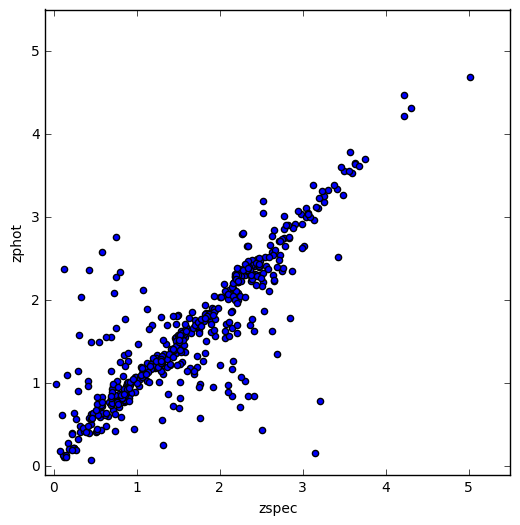

In [6]:
fig = plt.figure(figsize=(6,6))
#plt.scatter(y,(X[:,0]-X[:,1]))
plt.scatter(ytest[:500],ypred)
plt.xlabel('zspec')
plt.ylabel('zphot')
plt.xlim([-0.1,5.5])
plt.ylim([-0.1,5.5])
plt.show()

We will use [`dask`](http://dask.pydata.org/en/latest/) to handle the fact that we don't have enough memory to process the full array size at once and the amount of free disk for swap is also insufficient.

In short, we define the task that we want to run, we created dask objects with those tasks for each object and then we do the computation.

In [13]:
from dask import compute, delayed

def process(Xin):
    return model.predict(Xin)

# Create dask objects
# Reshape is necessary because the format of x as drawm from Xtest 
# is not what sklearn wants.
dobjs = [delayed(process)(x.reshape(1,-1)) for x in Xtest]
#print dobjs

In [14]:
#%%timeit
import dask.threaded
ypredselfNW = compute(*dobjs, get=dask.threaded.get)

In [15]:
# The dask output is sort of odd, so this is just to put the result back into the expected format.
ypredselfNW = np.array(ypredselfNW).reshape(1,-1)[0]

In [16]:
print len(ypredselfNW),ypredselfNW.max()

46884 6.117000103


Normally, I compute the fraction that are within $\Delta z$ of 0.1 or 0.3 as my diagnostic.   Ideally shooting for 90% within 0.3.

In [17]:
n = len(ypredselfNW)
mask1 = (np.abs(ypredselfNW-ytest)<0.1)
mask3 = (np.abs(ypredselfNW-ytest)<0.3)
m1 = len(ypredselfNW[mask1])
m3 = len(ypredselfNW[mask3])

frac1 = 1.0*m1/n
frac3 = 1.0*m3/n

print frac1,frac3

0.527685351079 0.827254500469


Can also compute [sklearn metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

In [18]:
from sklearn.metrics import explained_variance_score
explained_variance_score(ytest, ypredselfNW)  

0.78023197007340839

explained variance is 0.78 for Xtest and is was undefined for XStest due to a nan in the output data array.

Note too bad, but could do better.  Let's look at a plot.

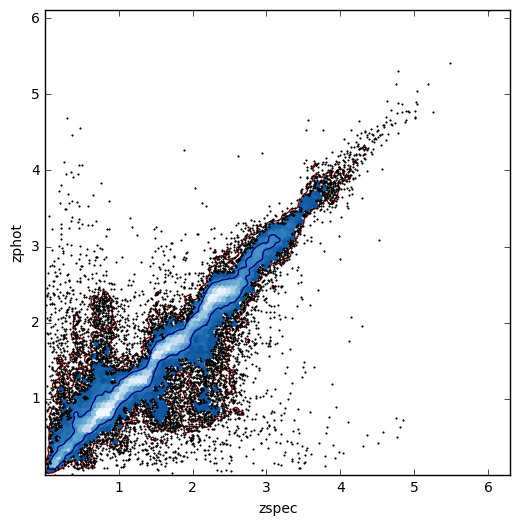

In [19]:
from densityplot import *
from pylab import *
fig = plt.figure(figsize=(6,6))
hex_scatter(ytest,ypredselfNW, min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.xlabel('zspec')
plt.ylabel('zphot')
#plt.xlim([-0.1,5.5])
#plt.ylim([-0.1,5.5])
plt.show()

In [36]:
# Another way to do implement dask
%%timeit
import dask.multiprocessing
ypred2 = compute(*dobjs, get=dask.multiprocessing.get)

1 loop, best of 3: 275 ms per loop


### Alternative Training Sets

I should really also look into trying training that that 
* include only high-$z$ quasars
* include the stars as $z=0$ objects

---
## Other Possible Photo-z Algorithms

### Random Forest

In [20]:
# Fit a Random Forest to the full spectroscopic sample
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor()
modelRF.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [21]:
ypredselfRFR = modelRF.predict(Xtest)

In [22]:
n = len(ypredselfRFR)
mask1 = (np.abs(ypredselfRFR-ytest)<0.1)
mask3 = (np.abs(ypredselfRFR-ytest)<0.3)
m1 = len(ypredselfRFR[mask1])
m3 = len(ypredselfRFR[mask3])

frac1 = 1.0*m1/n
frac3 = 1.0*m3/n

print frac1,frac3

0.487991638939 0.796924323863


In [23]:
from sklearn.metrics import explained_variance_score
explained_variance_score(ytest, ypredselfRFR)  

0.79332764599284344

Not as good as Nadaraya-Watson.  Let's look at a plot to see why.

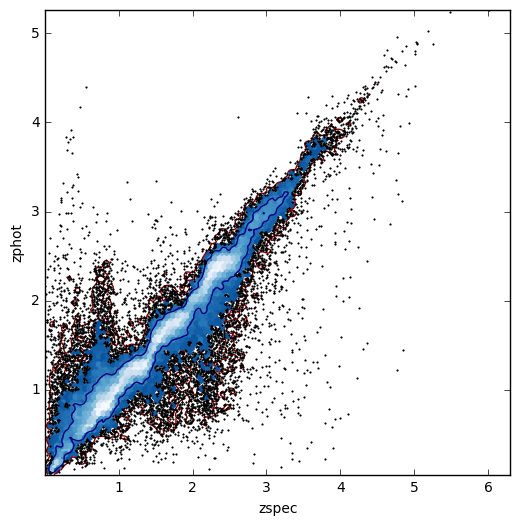

In [24]:
from densityplot import *
from pylab import *
fig = plt.figure(figsize=(6,6))
hex_scatter(ytest,ypredselfRFR, min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.xlabel('zspec')
plt.ylabel('zphot')
#plt.xlim([-0.1,5.5])
#plt.ylim([-0.1,5.5])
plt.show()

Not obvious, looks about the same.

### Gaussian Process Regression

The kernel dies on the *training* of this one.  Which is too bad as it seems powerful.  Should play with it and see if some combination of parameters can be made to work.  But note that Nadaraya-Watson is already a Kernel Gaussian Regressor.


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor()
gp.fit(Xtrain,ytrain)

In [ ]:
ypredselfGP = gp.predict(Xtest)

In [ ]:
n = len(ypredselfGP)
mask1 = (np.abs(ypredselfGP-ytest)<0.1)
mask3 = (np.abs(ypredselfGP-ytest)<0.3)
m1 = len(ypredselfGP[mask1])
m3 = len(ypredselfGP[mask3])

frac1 = 1.0*m1/n
frac3 = 1.0*m3/n

print frac1,frac3

In [ ]:
from sklearn.metrics import explained_variance_score
explained_variance_score(ytest, ypredselfGP)  

In [ ]:
from densityplot import *
from pylab import *
fig = plt.figure(figsize=(6,6))
hex_scatter(ytest,ypredselfGP, min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.xlabel('zspec')
plt.ylabel('zphot')
#plt.xlim([-0.1,5.5])
#plt.ylim([-0.1,5.5])
plt.show()

### SVM

This takes a **long** time to train!

In [ ]:
from sklearn import svm
model = svm.SVR(max_iter=10)
model.fit(Xtrain, ytrain) 

In [12]:
# Use dask instead
# ypredselfSVM = model.predict(Xtest)

In [ ]:
from dask import compute, delayed

def process(Xin):
    return model.predict(Xin)

dobjs = [delayed(process)(x.reshape(1,-1)) for x in Xtest]

In [ ]:
import dask.threaded
ypredselfSVM = compute(*dobjs, get=dask.threaded.get)

In [ ]:
ypredselfSVM = np.array(ypredselfSVM).reshape(1,-1)[0]

In [ ]:
n = len(ypredselfSVM)
mask1 = (np.abs(ypredselfSVM-ytest)<0.1)
mask3 = (np.abs(ypredselfSVM-ytest)<0.3)
m1 = len(ypredselfSVM[mask1])
m3 = len(ypredselfSVM[mask3])

frac1 = 1.0*m1/n
frac3 = 1.0*m3/n

print frac1,frac3

In [ ]:
from sklearn.metrics import explained_variance_score
explained_variance_score(ytest, ypredselfSVM)  

In [ ]:
from densityplot import *
from pylab import *
fig = plt.figure(figsize=(6,6))
hex_scatter(ytest,ypredselfSVM, min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.xlabel('zspec')
plt.ylabel('zphot')
#plt.xlim([-0.1,5.5])
#plt.ylim([-0.1,5.5])
plt.show()

### Stochastic Gradient Descent

In [25]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor()
model.fit(Xtrain, ytrain)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [26]:
ypredselfSGD = model.predict(XStest)

In [27]:
n = len(ypredselfSGD)
mask1 = (np.abs(ypredselfSGD-ytest)<0.1)
mask3 = (np.abs(ypredselfSGD-ytest)<0.3)
m1 = len(ypredselfSGD[mask1])
m3 = len(ypredselfSGD[mask3])

frac1 = 1.0*m1/n
frac3 = 1.0*m3/n

print frac1,frac3

0.0808804709496 0.240252538179


In [28]:
from sklearn.metrics import explained_variance_score
explained_variance_score(ytest, ypredselfSGD)  

0.00067731721765440511

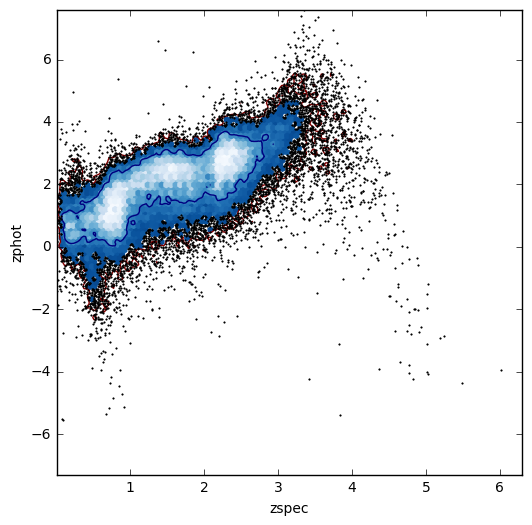

In [29]:
from densityplot import *
from pylab import *
fig = plt.figure(figsize=(6,6))
hex_scatter(ytest,ypredselfSGD, min_cnt=10, levels=2, std=True, smoothing=1,
            hkwargs={'gridsize': 100, 'cmap': plt.cm.Blues}, 
            skwargs={'color': 'k'})
plt.xlabel('zspec')
plt.ylabel('zphot')
#plt.xlim([-0.1,5.5])
#plt.ylim([-0.1,5.5])
plt.show()

Interesting.  This is terrible, but there are essentially no outliers.  I wonder if it is worth trying to use as a prior?

In [30]:
junk = Table.read('GTR-ADM-QSO-ir_good_test_2016_out_Stripe82all.fits')

In [32]:
print junk.keys()

['ra', 'dec', 'iflux', 'morph', 'knownqso', 'extinctu', 'ug', 'gr', 'ri', 'iz', 'zs1', 's1s2', 'ypredRFC', 'ypredSVM', 'ypredBAG']


In [31]:
print len(junk)

2029149
